## Download Data

In [1]:
import os
import opendatasets as od

from pathlib import Path


In [2]:
def download_data(source: str) -> Path:
    """Downloads dataset from kaggle link."""
    data_path = Path(source.split("/")[4] + "/")
    print(data_path)

    # Check if folder exists
    if data_path.is_dir():
        print(f"[INFO] {data_path} directory already exists, skipping download.")
    else:
        print(f"[INFO] Did not find {data_path} directory, creating one...")
        od.download("https://www.kaggle.com/competitions/dog-breed-identification/data")

    return data_path


In [3]:
data_path = download_data("https://www.kaggle.com/competitions/dog-breed-identification/data")


dog-breed-identification
[INFO] dog-breed-identification directory already exists, skipping download.


## Explore Data

### Look at Top 10 breeds

In [4]:
import pandas as pd


In [5]:
df_breeds = pd.read_csv("dog-breed-identification\labels.csv")
df_breeds


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
...,...,...
10217,ffd25009d635cfd16e793503ac5edef0,borzoi
10218,ffd3f636f7f379c51ba3648a9ff8254f,dandie_dinmont
10219,ffe2ca6c940cddfee68fa3cc6c63213f,airedale
10220,ffe5f6d8e2bff356e9482a80a6e29aac,miniature_pinscher


In [6]:
# Count no of images for each breed
df_breeds_count = df_breeds.groupby(["breed"])["id"].count()
df_breeds_count


breed
affenpinscher                      80
afghan_hound                      116
african_hunting_dog                86
airedale                          107
american_staffordshire_terrier     74
                                 ... 
welsh_springer_spaniel             79
west_highland_white_terrier        81
whippet                            95
wire-haired_fox_terrier            82
yorkshire_terrier                  82
Name: id, Length: 120, dtype: int64

In [7]:
# Look at top 10 breeds with most images
df_breeds_count_top = df_breeds_count.sort_values(ascending=False)
df_breeds_count_top[:10]


breed
scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
shih-tzu                112
great_pyrenees          111
pomeranian              111
basenji                 110
samoyed                 109
Name: id, dtype: int64

### View some images of the top 10 breeds

In [8]:
import random
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image


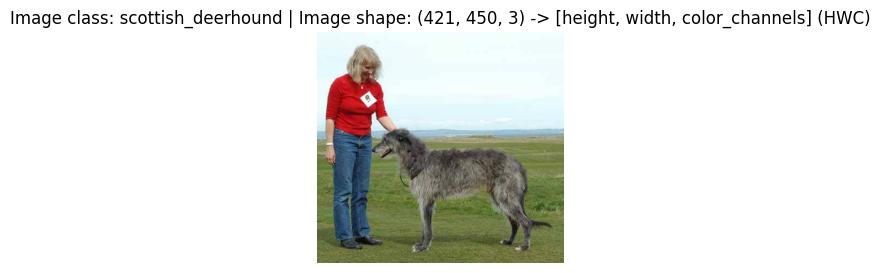

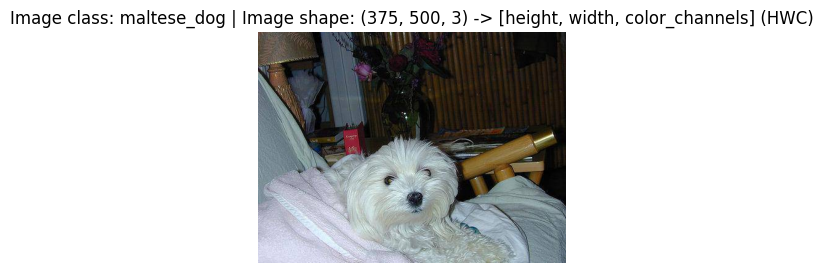

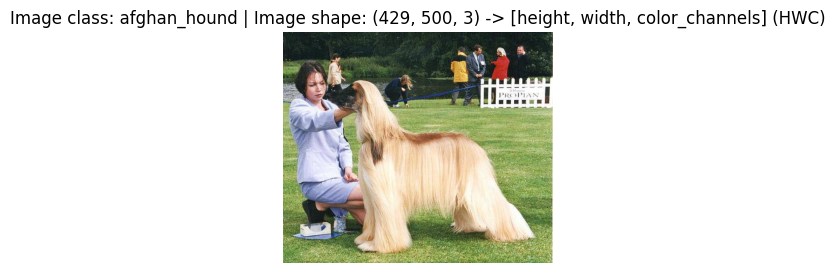

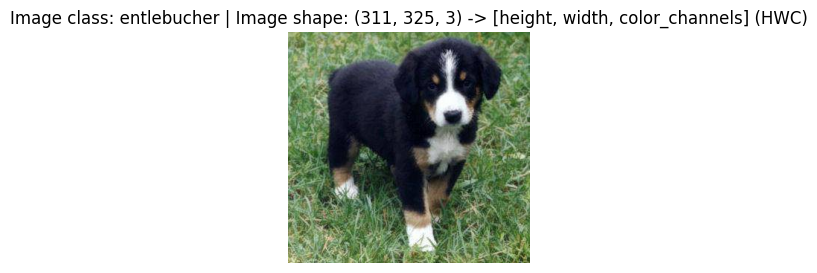

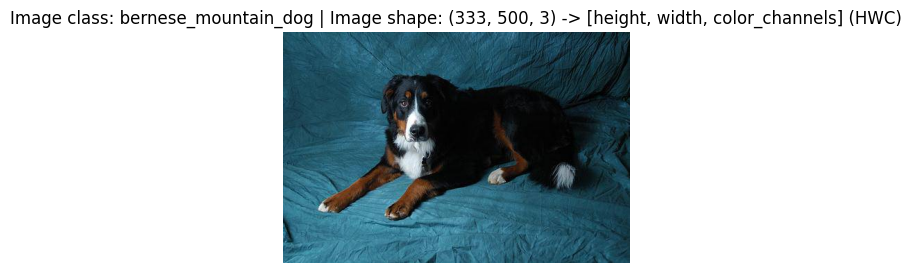

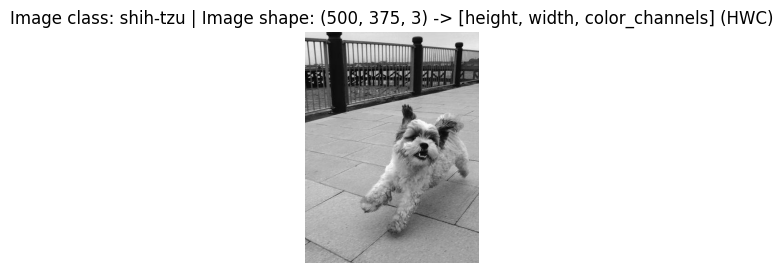

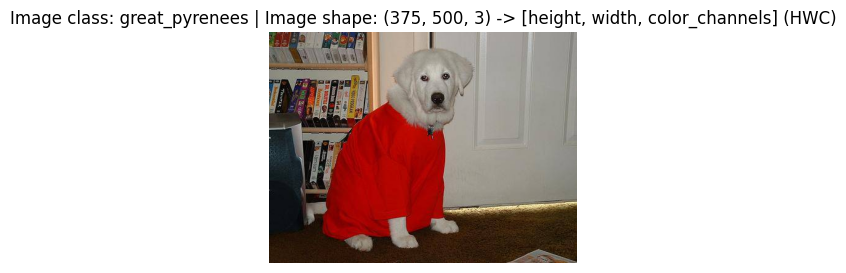

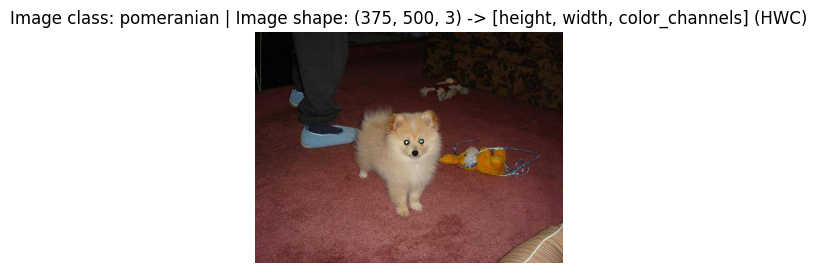

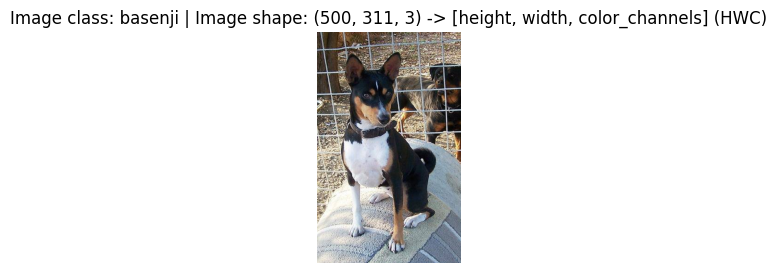

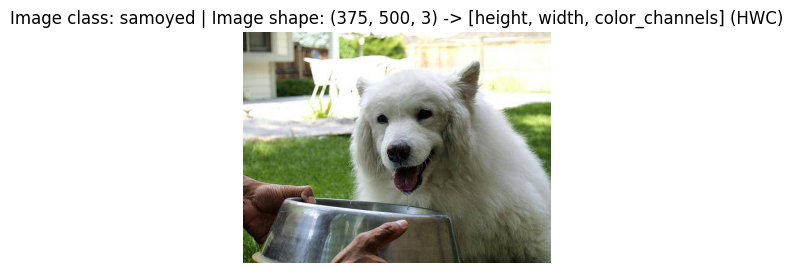

In [9]:
# Plot one image for each breed in the top 10 from train set
for breed in df_breeds_count_top[:10].index:
    # Get list of images for that breed
    df_selected_breed = df_breeds[df_breeds["breed"] == breed]
    image_list = df_selected_breed["id"].tolist()

    # Select random image
    random_image = random.choice(image_list)

    # Create image path
    image_path = "dog-breed-identification/train/" + random_image + ".jpg"
    image = Image.open(image_path)

    image_as_array = np.asarray(image)

    # Want 2 columns, 5 rows of images

    # Plot the image with matplotlib
    plt.figure(figsize=(5, 3))
    plt.imshow(image_as_array)
    plt.title(
        f"Image class: {breed} | Image shape: {image_as_array.shape} -> [height, width, color_channels] (HWC)"
    )
    plt.axis(False)


Noticed that there are some images where the dog covers only a small part of the image. May need bounding boxes to determine where exactly the dog is.

### Set up dataloaders

As data downloaded is not in the format needed for `datasets.ImageFolder`, we will need to write some code to create a new folder which is in the format required. We will also need to split the train data into train and test data.

In [10]:
import shutil

from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split


c:\Projects\dog-breed-classification\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
X = df_breeds["id"]
y = df_breeds["breed"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)


In [12]:
df_train = pd.concat([X_train, y_train], axis=1).reset_index()
df_test = pd.concat([X_test, y_test], axis=1).reset_index()


In [13]:
# Create folder for data in the required format

for type in ["train", "test"]:
    # Create train and test folders

    folder_directory = data_path / "formatted" / type

    if type == "train":
        df = df_train
    elif type == "test":
        df = df_test
    else:
        print("ERROR")

    # Check if folder exists
    if folder_directory.is_dir():
        print(f"[INFO] {folder_directory} directory already exists.")
    else:
        print(f"[INFO] Did not find {folder_directory} directory, creating one...")
        os.makedirs(folder_directory)

    for breed in tqdm(df_breeds_count.index):
        breed_folder_path = folder_directory / breed
        if breed_folder_path.is_dir():
            print(f"[INFO] {breed_folder_path} directory already exists.")
        else:
            print(f"[INFO] Did not find {breed_folder_path} directory, creating one...")
            os.mkdir(breed_folder_path)

            df_selected_breed = df[df["breed"] == breed]
            image_list = df_selected_breed["id"].tolist()

            for image in image_list:
                image_name = image + ".jpg"
                source_image_path = data_path / "train" / image_name
                destination_image_path = data_path / "formatted" / type / breed / image_name

                # Check if file exists in source
                shutil.copy(source_image_path, destination_image_path)


[INFO] dog-breed-identification\formatted\train directory already exists.


100%|██████████| 120/120 [00:00<00:00, 12001.44it/s]


[INFO] dog-breed-identification\formatted\train\affenpinscher directory already exists.
[INFO] dog-breed-identification\formatted\train\afghan_hound directory already exists.
[INFO] dog-breed-identification\formatted\train\african_hunting_dog directory already exists.
[INFO] dog-breed-identification\formatted\train\airedale directory already exists.
[INFO] dog-breed-identification\formatted\train\american_staffordshire_terrier directory already exists.
[INFO] dog-breed-identification\formatted\train\appenzeller directory already exists.
[INFO] dog-breed-identification\formatted\train\australian_terrier directory already exists.
[INFO] dog-breed-identification\formatted\train\basenji directory already exists.
[INFO] dog-breed-identification\formatted\train\basset directory already exists.
[INFO] dog-breed-identification\formatted\train\beagle directory already exists.
[INFO] dog-breed-identification\formatted\train\bedlington_terrier directory already exists.
[INFO] dog-breed-identifica

100%|██████████| 120/120 [00:00<00:00, 11997.72it/s]

[INFO] dog-breed-identification\formatted\test\affenpinscher directory already exists.
[INFO] dog-breed-identification\formatted\test\afghan_hound directory already exists.
[INFO] dog-breed-identification\formatted\test\african_hunting_dog directory already exists.
[INFO] dog-breed-identification\formatted\test\airedale directory already exists.
[INFO] dog-breed-identification\formatted\test\american_staffordshire_terrier directory already exists.
[INFO] dog-breed-identification\formatted\test\appenzeller directory already exists.
[INFO] dog-breed-identification\formatted\test\australian_terrier directory already exists.
[INFO] dog-breed-identification\formatted\test\basenji directory already exists.
[INFO] dog-breed-identification\formatted\test\basset directory already exists.
[INFO] dog-breed-identification\formatted\test\beagle directory already exists.
[INFO] dog-breed-identification\formatted\test\bedlington_terrier directory already exists.
[INFO] dog-breed-identification\format

In [14]:
import torchvision


In [15]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT  # "DEFAULT" = best available weights
weights


EfficientNet_B0_Weights.IMAGENET1K_V1

In [16]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms


ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [17]:
# Setup new directory path
train_dir = data_path / "formatted" / "train"
test_dir = data_path / "formatted" / "test"

train_dir, test_dir


(WindowsPath('dog-breed-identification/formatted/train'),
 WindowsPath('dog-breed-identification/formatted/test'))

In [18]:
from utils import data_setup

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir, test_dir=test_dir, transform=auto_transforms, batch_size=32
)
train_dataloader, test_dataloader, class_names


(<torch.utils.data.dataloader.DataLoader at 0x25eaa21a940>,
 ['affenpinscher',
  'afghan_hound',
  'african_hunting_dog',
  'airedale',
  'american_staffordshire_terrier',
  'appenzeller',
  'australian_terrier',
  'basenji',
  'basset',
  'beagle',
  'bedlington_terrier',
  'bernese_mountain_dog',
  'black-and-tan_coonhound',
  'blenheim_spaniel',
  'bloodhound',
  'bluetick',
  'border_collie',
  'border_terrier',
  'borzoi',
  'boston_bull',
  'bouvier_des_flandres',
  'boxer',
  'brabancon_griffon',
  'briard',
  'brittany_spaniel',
  'bull_mastiff',
  'cairn',
  'cardigan',
  'chesapeake_bay_retriever',
  'chihuahua',
  'chow',
  'clumber',
  'cocker_spaniel',
  'collie',
  'curly-coated_retriever',
  'dandie_dinmont',
  'dhole',
  'dingo',
  'doberman',
  'english_foxhound',
  'english_setter',
  'english_springer',
  'entlebucher',
  'eskimo_dog',
  'flat-coated_retriever',
  'french_bulldog',
  'german_shepherd',
  'german_short-haired_pointer',
  'giant_schnauzer',
  'golden_r

## Build Model

### Get Pretrained model

In [19]:
import torch


In [20]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

In [21]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT  # ".DEFAULT" = best available weights
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [22]:
model.classifier


Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [23]:
# Print with torchinfo
from torchinfo import summary

summary(
    model=model,
    input_size=(1, 3, 224, 224),  # example of [batch_size, color_channels, height, width]
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"],
)


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

In [24]:
# Freeze all of the base layers in EffNetB0
for param in model.features.parameters():
    param.requires_grad = False


In [25]:
len(class_names)


120

In [26]:
# Update the classifier head of our model to suit our problem
from torch import nn

torch.manual_seed(42)
torch.cuda.manual_seed(42)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names)),
).to(device)

model.classifier


Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=120, bias=True)
)

In [27]:
summary(
    model=model,
    input_size=(1, 3, 224, 224),  # example of [batch_size, color_channels, height, width]
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"],
)


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 120]             --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

### Train model

In [28]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [29]:
# Import train function
from utils import engine

# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer

start_time = timer()

# Setup training and save the results
results = engine.train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=10,
    device=device,
)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")


 10%|█         | 1/10 [03:02<27:26, 182.90s/it]

Epoch: 1 | train_loss: 2.9721 | train_acc: 0.4125 | test_loss: 1.7821 | test_acc: 0.6457


 20%|██        | 2/10 [05:03<19:31, 146.50s/it]

Epoch: 2 | train_loss: 1.4974 | train_acc: 0.6928 | test_loss: 1.3597 | test_acc: 0.6798


 30%|███       | 3/10 [07:14<16:15, 139.33s/it]

Epoch: 3 | train_loss: 1.1123 | train_acc: 0.7643 | test_loss: 1.2172 | test_acc: 0.6893


 40%|████      | 4/10 [09:45<14:22, 143.70s/it]

Epoch: 4 | train_loss: 0.9015 | train_acc: 0.8030 | test_loss: 1.1476 | test_acc: 0.6922


 50%|█████     | 5/10 [13:00<13:31, 162.35s/it]

Epoch: 5 | train_loss: 0.7683 | train_acc: 0.8322 | test_loss: 1.0677 | test_acc: 0.7075


 60%|██████    | 6/10 [15:48<10:56, 164.12s/it]

Epoch: 6 | train_loss: 0.6653 | train_acc: 0.8527 | test_loss: 1.0290 | test_acc: 0.7041


 70%|███████   | 7/10 [18:07<07:48, 156.02s/it]

Epoch: 7 | train_loss: 0.5996 | train_acc: 0.8698 | test_loss: 1.0816 | test_acc: 0.6883


 80%|████████  | 8/10 [20:33<05:05, 152.72s/it]

Epoch: 8 | train_loss: 0.5236 | train_acc: 0.8876 | test_loss: 1.0308 | test_acc: 0.7122


 90%|█████████ | 9/10 [23:31<02:40, 160.79s/it]

Epoch: 9 | train_loss: 0.4752 | train_acc: 0.9044 | test_loss: 1.0522 | test_acc: 0.6995


100%|██████████| 10/10 [25:51<00:00, 155.12s/it]

Epoch: 10 | train_loss: 0.4322 | train_acc: 0.9084 | test_loss: 1.0660 | test_acc: 0.7024
[INFO] Total training time: 1551.202 seconds


### Loss curves

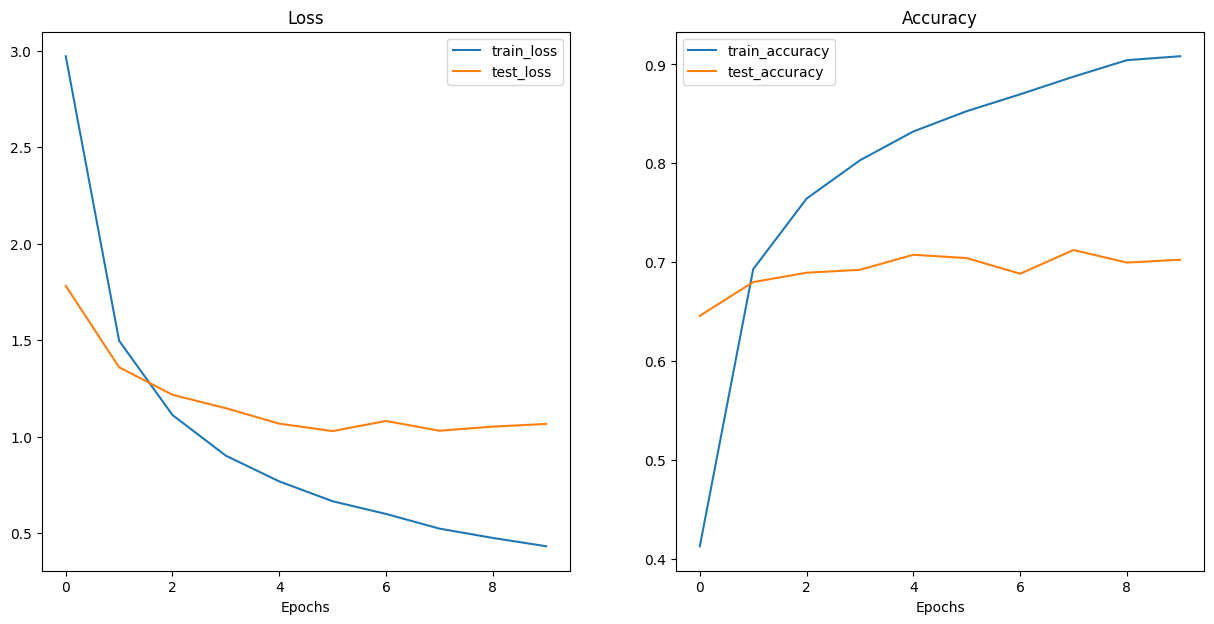

In [30]:
from utils.helper_functions import plot_loss_curves

plot_loss_curves(results)


In [31]:
model_name = "effnetb0"
epochs = 10


In [32]:
from utils.utils import save_model


In [33]:
save_filepath = f"{model_name}_{epochs}_epochs.pth"
save_model(model=model, target_dir="models", model_name=save_filepath)


[INFO] Saving model to: models\effnetb0_10_epochs.pth
